In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import skew, kurtosis

# Nạp dữ liệu
save_dir = r"C:\Users\minhp\PycharmProjects\SoFIFA\Data"
file_name = "cleaned_sofifa_players.csv"
file_path = os.path.join(save_dir, file_name)
df = pd.read_csv(file_path, encoding="utf-8")

<Figure size 600x600 with 0 Axes>

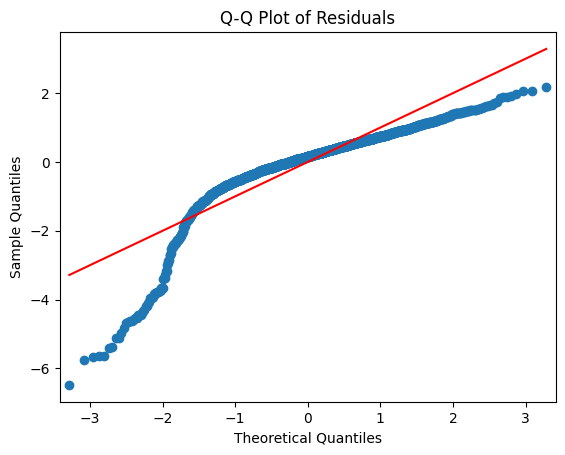

                             Test        Result
0     Ramsey RESET Test (p-value)  1.776649e-04
1         Durbin-Watson Statistic  1.994995e+00
2  Breusch-Godfrey Test (p-value)  1.472811e-01
3    Breusch-Pagan Test (p-value)  1.020291e-48
4           Skewness of Residuals -2.391099e+00
5           Kurtosis of Residuals  8.797212e+00


In [2]:
# Loại bỏ các hàng có giá trị Value = 0
df = df[df["Value"] > 0]

# Chỉ chọn các biến số
numeric_df = df.select_dtypes(include=["number"])

# Loại bỏ outliers bằng IQR
Q1 = df["Value"].quantile(0.25)
Q3 = df["Value"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df["Value"] >= lower_bound) & (df["Value"] <= upper_bound)].copy()

# Áp dụng log cho các biến có giá trị lớn để giảm ảnh hưởng của outliers
for col in ["Value", "Wage", "Base stats", "Shot power"]:
    df_filtered[col] = np.log1p(df_filtered[col])  # log(1 + x) để tránh log(0)

# Chọn tập biến cơ bản
new_features = ["Overall Rating", "Potential", "Wage", "Base stats",
                "dribbling/positioning", "passing/kicking", "Reactions", "Shot power",
                "Vision", "Strength", "Acceleration", "Composure"]

# Tạo các biến tương tác và phi tuyến
df_filtered["Wage_x_Overall"] = df_filtered["Wage"] * df_filtered["Overall Rating"]
df_filtered["Potential_x_Reactions"] = df_filtered["Potential"] * df_filtered["Reactions"]
df_filtered["Wage_sq"] = df_filtered["Wage"] ** 2
df_filtered["Overall_sq"] = df_filtered["Overall Rating"] ** 2

# Cập nhật danh sách biến với biến tương tác và phi tuyến mới
final_features = new_features + ["Wage_x_Overall", "Potential_x_Reactions", "Wage_sq", "Overall_sq"]

# Tạo tập dữ liệu mới với các biến đã lọc
X_final = df_filtered[final_features]
y_final = df_filtered["Value"]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled_final = scaler.fit_transform(X_final)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_scaled_final, y_final, test_size=0.2, random_state=42)

# Chạy mô hình
X_train_const_final = sm.add_constant(X_train_final)
ols_model_final = sm.OLS(y_train_final, X_train_const_final).fit()

# Kiểm định hồi quy
tests = {
    "Ramsey RESET Test (p-value)": linear_reset(ols_model_final, power=2, use_f=True).pvalue,
    "Durbin-Watson Statistic": durbin_watson(ols_model_final.resid),
    "Breusch-Godfrey Test (p-value)": acorr_breusch_godfrey(ols_model_final, nlags=2)[1],
    "Breusch-Pagan Test (p-value)": het_breuschpagan(ols_model_final.resid, X_train_const_final)[1],
    "Skewness of Residuals": skew(ols_model_final.resid),
    "Kurtosis of Residuals": kurtosis(ols_model_final.resid)
}

# Vẽ Q-Q Plot
plt.figure(figsize=(6, 6))
sm.qqplot(ols_model_final.resid, line='s', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Hiển thị kết quả kiểm định
print(pd.DataFrame(tests.items(), columns=["Test", "Result"]))



In [3]:
ols_model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     1267.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:04:26   Log-Likelihood:                -677.93
No. Observations:                1964   AIC:                             1390.
Df Residuals:                    1947   BIC:                             1485.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0908      0.008   1946.702      0.000      15.076      15.106
x1             0.5049      0.219      2.302      0.021       0.075       0.935
x2            -0.2844      0.076     -3.751      0.000      -0.433      -0.136
x3            -0.3683      0.167     -2.205      0.028      -0.696      -0.041
x4            -0.0830      0.027     -3.106      0.002      -0.135      -0.031
x5            -0.0130      0.017     -0.750      0.454      -0.047       0.021
x6            -0.0138      0.025     -0.543      0.587      -0.064       0.036
x7            -1.4717      0.161     -9.139      0.000      -1.788      -1.156
x8             0.0257      0.011      2.249      0.025       0.003       0.048
x9             0.1096      0.018      6.094      0.000       0.074       0.145
x10            0.0414      0.013      3.169      0.002       0.016       0.067
x11            0.1338      0.013     10.106      0.000       0.108       0.160
x12           -0.0562      0.016     -3.546      0.000      -0.087      -0.025
x13            1.1772      0.347      3.388      0.001       0.496       1.859
x14            1.8288      0.204      8.962      0.000       1.429       2.229
x15           -0.1858      0.251     -0.739      0.460      -0.679       0.307
x16           -0.3687      0.245     -1.506      0.132      -0.849       0.111
==============================================================================
Omnibus:                     1040.760   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8204.640
Skew:                          -2.391   Prob(JB):                         0.00
Kurtosis:                      11.797   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""